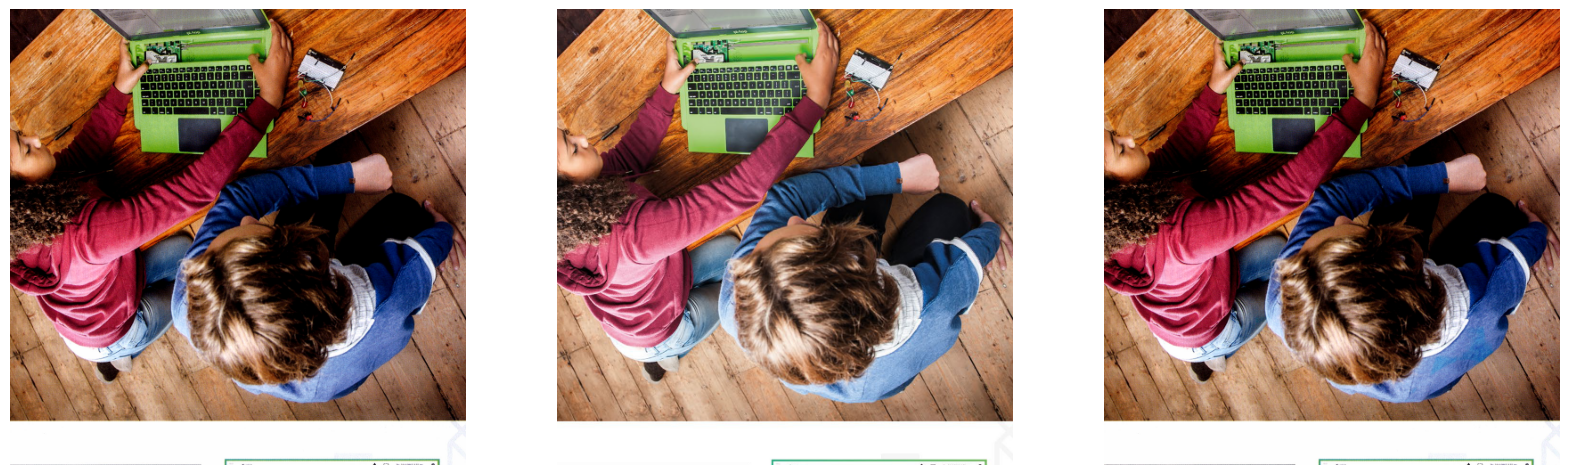

RuntimeError: MPS backend out of memory (MPS allocated: 14.19 GB, other allocations: 4.20 GB, max allowed: 18.13 GB). Tried to allocate 512.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [16]:
import random
import numpy as np
import cv2
import os
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from os.path import join
from os import listdir
from torchsummary import summary
import time
import argparse
import models.models.DnCNN as DnCNN, models.models.ResNet as ResNet
# from models.utils.param import param_check, seed_everything
import models.utils.vgg_loss, models.utils.vgg_perceptual_loss
import matplotlib.pyplot as plt


model_list = ['DnCNN','ResNet18']
set_model = model_list[1]
display_number = 10                                    # plt로 디스플레이할 이미지의 개수
residual_output_paths = '/content/residuals'           # 잔차 이미지를 저장할 폴더
noisy_image_paths = '../local_datasets/MLinP/train/scan'
clean_image_paths = '../local_datasets/MLinP/train/clean'
pth_dir='./save/best_ResNet18_model4.pth'

output = False                                         # residual을 파일로 출력할지 여부


def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = [join(noisy_image_paths, x) for x in listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])
        
        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path
    
if set_model == 'DnCNN':
    model = DnCNN.DnCNN()
elif set_model == 'ResNet18':
    model = ResNet.ResNet18()

device = torch.device('cuda' if torch.cuda.is_available() else 'mps:0' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
model.load_state_dict(torch.load(pth_dir, map_location='cpu'))
model.eval()

# GPU 사용 여부 확인
model.to(device)

test_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드 및 전처리
noisy_dataset = CustomDatasetTest(noisy_image_paths, transform=test_transform)
clean_dataset = CustomDatasetTest(clean_image_paths, transform=test_transform)

# 데이터 로더 설정
noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
clean_loader = DataLoader(clean_dataset, batch_size=1, shuffle=False)


# residuals = torch.Tensor(51, 512, 512, 3)
for i, ((noisy_image, noisy_image_path), (clean_image, clean_image_path) ) in enumerate(zip(noisy_loader,clean_loader)):
    # print(clean_image.shape)
    residual_image = clean_image[0]-noisy_image[0]
    # residuals[i] = residual_image
    noisy_image = noisy_image.to(device)
    noise = model(noisy_image)
    denoised_image = noisy_image - noise
    noisy_image = noisy_image.to('cpu')
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    # denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = ToPILImage()(denoised_image*0.5+0.5)

    noisy_image = noisy_image.cpu().squeeze(0)
    # noisy_image = torch.clamp(noisy_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    noisy_image = ToPILImage()(noisy_image*0.5+0.5)

    clean_image = clean_image.cpu().squeeze(0)
    # clean_image = torch.clamp(clean_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    clean_image = ToPILImage()(clean_image*0.5+0.5)

    if(i<display_number):
        plt.figure(figsize=(20,20))
        plt.subplot(1,3,1)
        plt.imshow(noisy_image)
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(clean_image)
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(denoised_image)
        plt.axis('off')
        plt.show()

    if output:
        output_filename = noisy_image_path[0]
        residual_filename = residual_output_paths + '/' + output_filename.split('\\')[-1][:-4].replace('\\',"/") + '.png'
        cv2.imwrite(residual_filename, np.array(residual_image))
    
    if(i==50):
        print(residual_image.shape)
        print(residual_image[0])
        break

# avg_residual = torch.mean(residuals,axis=0)

In [ ]:
  
model_list = ['DnCNN','ResNet18']
set_model = model_list[0]

if set_model == 'DnCNN':
    model = DnCNN.DnCNN()
elif set_model == 'ResNet18':
    model = resnet.ResNet18()

pth_dir='./save/best_DnCNN_model17.pth'
model.load_state_dict(torch.load(pth_dir))
model.eval()

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'mps:0' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

test_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드 및 전처리
print('전처리 실행')
noisy_dataset = CustomDatasetTest(noisy_image_paths, model, transform=test_transform)

# 데이터 로더 설정
noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)